## Geological Image Similarity: Test_Code

**BACKGROUND:**

A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool
will possess a search capability whereby an analyst provides an image of interest and is presented with other images
which are similar to it.

**GOAL:**

Task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.

*[Information from Kaggle]*


In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

#### Global Variables

In [2]:
rock_name = ['andesite','gneiss','marble','quartzite','rhyolite','schist']

GEO_PATH = ['./geological_similarity/'+r+'/' for r in rock_name]

N_ROCK = len(rock_name)         # no. of rock classes
SAMP = 5                        # number of images to be inspected per class           

In [3]:
# VALIDATE: Count number of images per Geo folder
import os

IMGS_PER_CLASS = [] # no. of images per class; no. of files to a folder

for i in range(N_ROCK):
    c = 0
    
    for path in os.listdir(GEO_PATH[i]):
        c += os.path.isfile(os.path.join(GEO_PATH[i], path))
            
    IMGS_PER_CLASS.append(c)

for i in range(N_ROCK):
    print(f'IMGS_PER_CLASS[{i}]:', IMGS_PER_CLASS[i])


IMGS_PER_CLASS[0]: 5000
IMGS_PER_CLASS[1]: 5000
IMGS_PER_CLASS[2]: 4998
IMGS_PER_CLASS[3]: 5000
IMGS_PER_CLASS[4]: 5000
IMGS_PER_CLASS[5]: 5000


#### Create Image Arrays; Assign Labels; Inspect Sample Images

In [4]:
# PLOT METHOD
def plot_sample_images(img):
    fig = plt.figure(figsize=(10,20))
    gs = fig.add_gridspec(1,SAMP)

    ax = [fig.add_subplot(gs[0,i]) for i in range(SAMP)]
    
    for j in range(SAMP):
        ax[j].imshow(img[j])
        ax[j].axis('off')
    
    plt.show()

Sample images for ANDESITE:


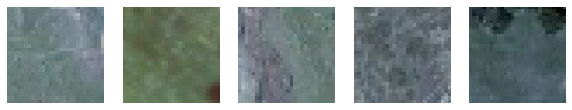

Sample images for GNEISS:


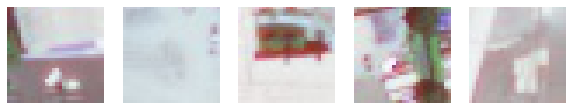

Sample images for MARBLE:


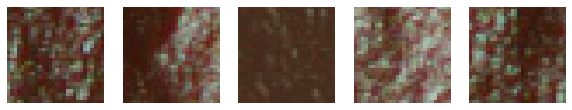

Sample images for QUARTZITE:


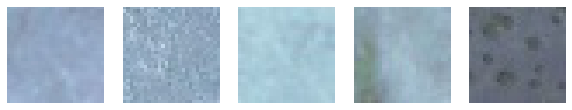

Sample images for RHYOLITE:


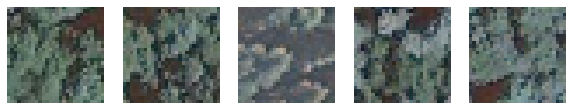

Sample images for SCHIST:


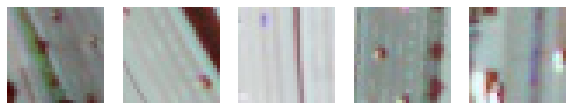

In [5]:
img_arr = []
labels = []

samples = [0] * N_ROCK 
samples = [[] for i in range(N_ROCK)]

for i in range(N_ROCK):
    print(f'Sample images for {rock_name[i].upper()}:')
    
    for idx, img in enumerate(os.listdir(GEO_PATH[i])):
        img = load_img(GEO_PATH[i] + img)
        
        if idx < SAMP:
            samples[i].append(img)
        
        img_arr.append(img_to_array(img))
        labels.append(i)
    
    plot_sample_images(samples[i])


In [6]:
# VALIDATE: image and label shapes
img_arr = np.array(img_arr)
labels = np.array(labels)

print(img_arr.shape)
print(labels.shape)

(29998, 28, 28, 3)
(29998,)


#### Split the Data

In [7]:
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data(images, labels, split=(0.6,0.2,0.2),aug_img=False):    
    ## create train/validation/test sets 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, labels = images[shuffle], labels[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels, [splits[0], splits[0]+splits[1]])
    
    ## image transformation on training, validation, and test data

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    ## image augmentation on training data 
    
    if aug_img:
        # adjust brightness
        X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

        # adjust contrast
        X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

        # random flip
        # X_train_augm = tf.image.random_flip_left_right(X_train_augm)

        # concatenate original X_train and augmented X_train data
        X_train = tf.concat([X_train, X_train_augm],axis=0)

        # concatenate y_train (note the label is preserved)
        y_train_augm = y_train
        y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(
    images=img_arr,
    labels=labels,
    split=(0.6,0.2,0.2),
    aug_img=False)

print("Validate shape")
print(f"   X_train shape {X_train.shape}")
print(f"   y_train shape {y_train.shape}")
print(f"   X_val shape {X_val.shape}")
print(f"   y_val shape {y_val.shape}")
print(f"   X_test shape {X_test.shape}")
print(f"   y_test shape {y_test.shape}")

Validate shape
   X_train shape (17998, 28, 28, 3)
   y_train shape (17998,)
   X_val shape (5999, 28, 28, 3)
   y_val shape (5999,)
   X_test shape (6001, 28, 28, 3)
   y_test shape (6001,)


#### Build Model

In [9]:
model = tf.keras.Sequential()

# first convolution layer
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

# max pooling layer with pool size (2,2), strides of 2
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

# second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_2'))

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))

# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              3212288   
                                                                 
 dropout (Dropout)           (None, 1024)              0

#### Compile Model

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

#### Fit Model

In [11]:
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val))


Epoch 1/10
563/563 [==============================] - 20s 35ms/step - loss: -19128719360.0000 - accuracy: 0.1670 - val_loss: -104110571520.0000 - val_accuracy: 0.1630
Epoch 2/10
563/563 [==============================] - 20s 36ms/step - loss: -657823498240.0000 - accuracy: 0.1674 - val_loss: -1672453029888.0000 - val_accuracy: 0.1630
Epoch 3/10
563/563 [==============================] - 21s 37ms/step - loss: -4044200083456.0000 - accuracy: 0.1674 - val_loss: -7432095399936.0000 - val_accuracy: 0.1630
Epoch 4/10
563/563 [==============================] - 22s 39ms/step - loss: -13100426199040.0000 - accuracy: 0.1674 - val_loss: -20431664840704.0000 - val_accuracy: 0.1630
Epoch 5/10
563/563 [==============================] - 22s 39ms/step - loss: -30915281551360.0000 - accuracy: 0.1674 - val_loss: -43642077052928.0000 - val_accuracy: 0.1630
Epoch 6/10
563/563 [==============================] - 23s 41ms/step - loss: -60208093069312.0000 - accuracy: 0.1674 - val_loss: -79722679631872.0000 -

#### Plot History Summary

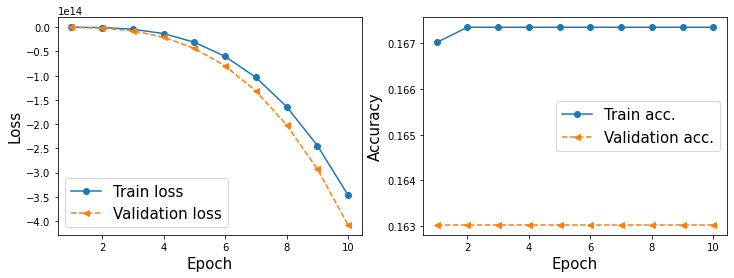

In [12]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()
